<a href="https://colab.research.google.com/github/asminimulin/cv-course/blob/main/03-image-classification-with-2layered-nn/TwoLayeredFullyConnectedNearalNetworkForClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений из набора CIFAR-10 с помощью нейронной сети с линейными полносвязными слоями.

## Получение датасета

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting content/cifar-10-python.tar.gz to content
Files already downloaded and verified


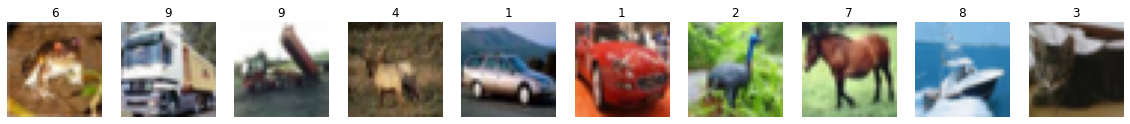

In [1]:
# Load dataset in Pytorch dataset class

from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

trainset = datasets.CIFAR10("content", train=True,  download=True)
testset = datasets.CIFAR10("content", train = False, download=True)

# Display some samples
for j in range(10):
  image, class_num = trainset[j]
  plt.subplot(1, 10 ,j+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(str(class_num))

## Подготовка функции валидации модели

In [2]:
# Validation function. Don't cahnge it
def validate(model,testloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
  return correct / total

## Реализация модели

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class TwoLayerFCN(nn.Module):
  def __init__(self, class_nums = 10):
    super(TwoLayerFCN, self).__init__()
    # Define two layer fully - connected network with linear layers: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
    self.layer_0 = nn.Linear(3072, 100)
    self.layer_1 = nn.Linear(100, class_nums, bias=False)

  def forward(self, x):
    """
    Perform forward pass
    Use self.layer_0 and self.layer_1 layers defined in constructor with RELU activation function
    Add activation function on your choice: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
    """
    x = F.relu(self.layer_0(x))
    x = F.relu(self.layer_1(x))
    return x


## Подготовка поднаборов данных для обучения и тетсирования

In [4]:
# Prepare the data
transform=transforms.Compose([
                              transforms.ToTensor(), # Pil Image to Pytorch tensor
                              transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)), # https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize
                              transforms.Lambda(lambda x: torch.flatten(x))
                              ])

trainset.transform = transform
testset.transform = transform

train_loader = DataLoader(trainset, batch_size = 512, shuffle = True)
test_loader = DataLoader(testset, batch_size = 256, shuffle = False)



## Проверка принципальной работоспособности модели

In [5]:
import torch.optim as optim

# Train the model
# You may change loss function, learning rate and number of epochs

model = TwoLayerFCN(10)
model.train()

# By default cross-entropy loss used, you can change it to another loss function
criterion = nn.CrossEntropyLoss() 

# You can change learning rate and number of epoch too
optimizer = optim.SGD(model.parameters(), lr=0.1)
for epoch in range(25):
  for img_batch, labels_batch in train_loader:
    optimizer.zero_grad()
    output = model(img_batch)
    loss = criterion(output, labels_batch)
    # Get the grad and update model weights: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#backprop

    # Put your code here
    loss.backward()
    optimizer.step()

  accuracy = validate(model,test_loader)
  print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(epoch,loss.item(),accuracy))
  

Epoch 0 Loss 1.70 Accuracy 0.41
Epoch 1 Loss 1.53 Accuracy 0.45
Epoch 2 Loss 1.48 Accuracy 0.47
Epoch 3 Loss 1.41 Accuracy 0.46
Epoch 4 Loss 1.41 Accuracy 0.48
Epoch 5 Loss 1.42 Accuracy 0.48
Epoch 6 Loss 1.33 Accuracy 0.47
Epoch 7 Loss 1.38 Accuracy 0.49
Epoch 8 Loss 1.25 Accuracy 0.50
Epoch 9 Loss 1.28 Accuracy 0.47
Epoch 10 Loss 1.41 Accuracy 0.47
Epoch 11 Loss 1.20 Accuracy 0.50
Epoch 12 Loss 1.38 Accuracy 0.49
Epoch 13 Loss 1.37 Accuracy 0.46
Epoch 14 Loss 1.35 Accuracy 0.48
Epoch 15 Loss 1.29 Accuracy 0.49
Epoch 16 Loss 1.12 Accuracy 0.49
Epoch 17 Loss 1.17 Accuracy 0.46
Epoch 18 Loss 1.26 Accuracy 0.47
Epoch 19 Loss 1.11 Accuracy 0.49
Epoch 20 Loss 1.17 Accuracy 0.49
Epoch 21 Loss 1.19 Accuracy 0.48
Epoch 22 Loss 1.09 Accuracy 0.49
Epoch 23 Loss 1.20 Accuracy 0.48
Epoch 24 Loss 1.27 Accuracy 0.49


**Промежуточный вывод.** Модель позовляет достичь accuracy=0.50 при learning_rate=0.1

## Новый класс модели, которую можно параметризовать различными функциями активации

In [6]:
class FCNet(nn.Module):

  def __init__(self, activation_func, class_nums = 10):
    super(FCNet, self).__init__()
    # Define two layer fully - connected network with linear layers: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
    self.layer_0 = nn.Linear(3072, 100)
    self.layer_1 = nn.Linear(100, class_nums, bias=False)
    self.activation_func = activation_func

  def forward(self, x):
    """
    Perform forward pass
    Use self.layer_0 and self.layer_1 layers defined in constructor with RELU activation function
    Add activation function on your choice: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
    """  
    y_0 = self.activation_func(self.layer_0(x))
    y_1 = self.activation_func(self.layer_1(y_0))
    return y_1


## Построим разные модели с ф-ией аквтивации RELU и сравним их в зависимости от оптимизатора Adam и SGD (with momentum)

In [7]:
class ReluFCNet:
  def __init__(self, optimizer_name, lr, steps=25):
    self.model = FCNet(F.relu)
    self.steps = steps
    self.learning_rate = lr
    self.optimizer_name = optimizer_name

  def train(self):
    self.model.train()
    criterion = nn.CrossEntropyLoss()
    self.loss_history = []
    optimizer = self.get_optimizer()
    loader = DataLoader(trainset, batch_size=trainset.data.shape[0] // self.steps, shuffle=True)
    for epoch in range(self.steps):
      for img_batch, labels_batch in loader:
        optimizer.zero_grad()
        output = self.model(img_batch)
        loss = criterion(output, labels_batch)
        loss.backward()
        optimizer.step()
        self.loss_history.append(loss.item())
        # print(f"loss={loss.item()}")
      accuracy = validate(self.model, test_loader)
      print("Epoch {} Loss {:.2f}  acc={:.2f}".format(epoch, loss.item(), accuracy))
    self.model.train(False)

  def get_accuracy(self):
    return validate(self.model, test_loader)

  def get_optimizer(self):
    if self.optimizer_name == 'SGD':
      return optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)
    if self.optimizer_name == 'Adam':
      return optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=0.0, betas=(0.9, 0.99))
    raise ValueError(f"Bad optimizer: {self.optimizer_name}")

### Сравним SGD и Adam варинаты градиентного спуска для оптимизации параметром модели

In [8]:
adam_model = ReluFCNet('Adam', lr=0.003, steps=25)
adam_model.train()

Epoch 0 Loss 1.90  acc=0.38
Epoch 1 Loss 1.76  acc=0.41
Epoch 2 Loss 1.57  acc=0.44
Epoch 3 Loss 1.51  acc=0.46
Epoch 4 Loss 1.43  acc=0.47
Epoch 5 Loss 1.38  acc=0.48
Epoch 6 Loss 1.36  acc=0.48
Epoch 7 Loss 1.35  acc=0.49
Epoch 8 Loss 1.30  acc=0.50
Epoch 9 Loss 1.27  acc=0.50
Epoch 10 Loss 1.21  acc=0.50
Epoch 11 Loss 1.21  acc=0.51
Epoch 12 Loss 1.19  acc=0.50
Epoch 13 Loss 1.20  acc=0.50
Epoch 14 Loss 1.16  acc=0.50
Epoch 15 Loss 1.14  acc=0.50
Epoch 16 Loss 1.06  acc=0.50
Epoch 17 Loss 1.13  acc=0.50
Epoch 18 Loss 1.04  acc=0.51
Epoch 19 Loss 1.08  acc=0.50
Epoch 20 Loss 1.01  acc=0.51
Epoch 21 Loss 1.03  acc=0.50
Epoch 22 Loss 0.98  acc=0.50
Epoch 23 Loss 0.95  acc=0.50
Epoch 24 Loss 0.98  acc=0.50


In [9]:
adam_acc = adam_model.get_accuracy()
print(f"adam_acc={adam_acc}")

adam_acc=0.4999


In [10]:
sgd_model = ReluFCNet('SGD', lr=0.12)
sgd_model.train()

Epoch 0 Loss 1.65  acc=0.42
Epoch 1 Loss 1.55  acc=0.45
Epoch 2 Loss 1.51  acc=0.47
Epoch 3 Loss 1.39  acc=0.48
Epoch 4 Loss 1.41  acc=0.49
Epoch 5 Loss 1.38  acc=0.48
Epoch 6 Loss 1.33  acc=0.49
Epoch 7 Loss 1.28  acc=0.49
Epoch 8 Loss 1.44  acc=0.48
Epoch 9 Loss 1.33  acc=0.49
Epoch 10 Loss 1.18  acc=0.51
Epoch 11 Loss 1.24  acc=0.49
Epoch 12 Loss 1.23  acc=0.50
Epoch 13 Loss 1.21  acc=0.50
Epoch 14 Loss 1.14  acc=0.49
Epoch 15 Loss 1.21  acc=0.49
Epoch 16 Loss 1.15  acc=0.50
Epoch 17 Loss 1.14  acc=0.50
Epoch 18 Loss 1.07  acc=0.51
Epoch 19 Loss 1.08  acc=0.49
Epoch 20 Loss 1.08  acc=0.50
Epoch 21 Loss 1.31  acc=0.50
Epoch 22 Loss 1.10  acc=0.49
Epoch 23 Loss 1.02  acc=0.49
Epoch 24 Loss 1.01  acc=0.50


In [11]:
sgd_acc = sgd_model.get_accuracy()
print(f"sgd_acc={sgd_acc}")

sgd_acc=0.4965


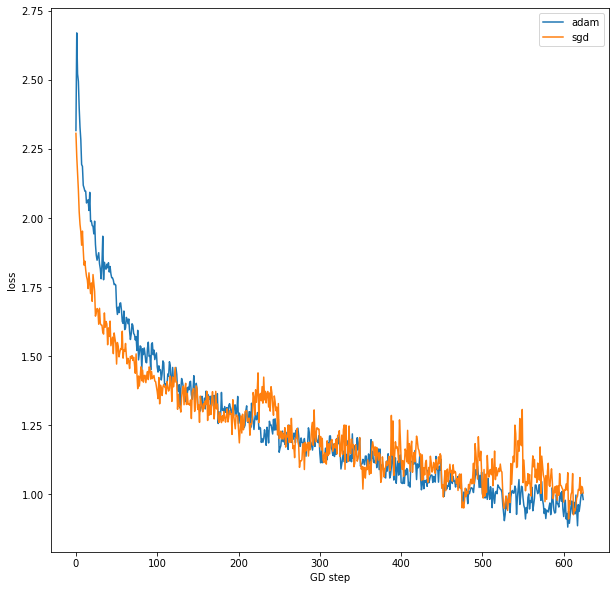

In [12]:
ax = plt.gca()
fig = plt.gcf()

for m, name in [(adam_model, "adam"), (sgd_model, "sgd")]:
  ax.plot(m.loss_history, label=name)

ax.legend()
ax.set_ylabel("loss")
ax.set_xlabel("GD step")
fig.set_size_inches(10, 10)
plt.show()

**Промежуточный вывод.** На графике видно, что модель построенная с помощью алгоритма оптимизации Adam работает с производительностью похожей на алгоритм SGD (with momentum) оптимизацией. Итоговая точность алгоритмов также схожая.

*Этого нет на графике, но видно по значениям, которые печатаются во время обучения.*
Обе модели лучше модели SGD без оптимизации momentum. Улчшение достигается за счет использования импульса с предыдущих шагов.


## Сравнение различных функций активации

### Создадим общую функцию для обучения моделей

In [13]:
def train_model(model, learning_rate = 0.1, steps=15, verbose=True):
  """Returns list loss_history containing loss value at every epoch of gradient descent.

  Be noted that the loss value after the model training is not included in loss_history since API of dataloader is not suited for such evaluation.
  """
  model.train()
  criterion = nn.CrossEntropyLoss() 

  loss_history = []
  # You can change learning rate and number of epoch too
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)
  for epoch in range(steps):
    for img_batch, labels_batch in train_loader:
      optimizer.zero_grad()
      output = model(img_batch)
      loss = criterion(output, labels_batch)
      loss.backward()
      optimizer.step()

    loss_history.append(loss.item())
    if verbose:
      acc = validate(model, test_loader)
      print("Epoch {} Loss {:.2f}   acc={:.2f}".format(epoch, loss.item(), acc))
  return loss_history

### Обучим модели с разными вариантами функции активации

In [16]:
activation_funcs = {
    'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh,
    'softsign': F.softsign,
    'sign': (lambda x: torch.sign(x))
}

train_results = {}

for f_name in activation_funcs:
  print(f"Training model with activation function = {f_name}")
  func = activation_funcs[f_name]
  model = FCNet(func)
  loss_history = train_model(model)
  train_results[f_name] = loss_history
  print("")


Training model with activation function = relu
Epoch 0 Loss 1.65   acc=0.41
Epoch 1 Loss 1.59   acc=0.44
Epoch 2 Loss 1.46   acc=0.47
Epoch 3 Loss 1.54   acc=0.45
Epoch 4 Loss 1.38   acc=0.48
Epoch 5 Loss 1.41   acc=0.49
Epoch 6 Loss 1.31   acc=0.47
Epoch 7 Loss 1.43   acc=0.48
Epoch 8 Loss 1.50   acc=0.49
Epoch 9 Loss 1.54   acc=0.47
Epoch 10 Loss 1.26   acc=0.48
Epoch 11 Loss 1.43   acc=0.43
Epoch 12 Loss 1.29   acc=0.50
Epoch 13 Loss 1.27   acc=0.49
Epoch 14 Loss 1.01   acc=0.51

Training model with activation function = sigmoid


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Loss 2.20   acc=0.30
Epoch 1 Loss 2.15   acc=0.32
Epoch 2 Loss 2.12   acc=0.33
Epoch 3 Loss 2.11   acc=0.33
Epoch 4 Loss 2.09   acc=0.34
Epoch 5 Loss 2.10   acc=0.34
Epoch 6 Loss 2.09   acc=0.35
Epoch 7 Loss 2.06   acc=0.35
Epoch 8 Loss 2.05   acc=0.35
Epoch 9 Loss 2.07   acc=0.36
Epoch 10 Loss 2.07   acc=0.36
Epoch 11 Loss 2.05   acc=0.36
Epoch 12 Loss 2.03   acc=0.37
Epoch 13 Loss 2.02   acc=0.37
Epoch 14 Loss 2.03   acc=0.37

Training model with activation function = tanh


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0 Loss 1.90   acc=0.37
Epoch 1 Loss 1.85   acc=0.39
Epoch 2 Loss 1.79   acc=0.39
Epoch 3 Loss 1.81   acc=0.40
Epoch 4 Loss 1.86   acc=0.41
Epoch 5 Loss 1.73   acc=0.41
Epoch 6 Loss 1.76   acc=0.42
Epoch 7 Loss 1.77   acc=0.43
Epoch 8 Loss 1.72   acc=0.43
Epoch 9 Loss 1.69   acc=0.43
Epoch 10 Loss 1.66   acc=0.44
Epoch 11 Loss 1.68   acc=0.44
Epoch 12 Loss 1.70   acc=0.44
Epoch 13 Loss 1.70   acc=0.44
Epoch 14 Loss 1.61   acc=0.44

Training model with activation function = softsign
Epoch 0 Loss 2.03   acc=0.35
Epoch 1 Loss 1.94   acc=0.35
Epoch 2 Loss 1.96   acc=0.36
Epoch 3 Loss 1.93   acc=0.36
Epoch 4 Loss 1.90   acc=0.37
Epoch 5 Loss 1.92   acc=0.37
Epoch 6 Loss 1.92   acc=0.37
Epoch 7 Loss 1.93   acc=0.38
Epoch 8 Loss 1.89   acc=0.38
Epoch 9 Loss 1.87   acc=0.39
Epoch 10 Loss 1.92   acc=0.38
Epoch 11 Loss 1.89   acc=0.39
Epoch 12 Loss 1.88   acc=0.39
Epoch 13 Loss 1.81   acc=0.39
Epoch 14 Loss 1.86   acc=0.39

Training model with activation function = sign
Epoch 0 Loss 2.73   

In [17]:
# activation_funcs = {
#     'relu': (F.relu, {'learning_rate': 0.1}),
#     'sigmoid': (F.sigmoid, {'learning_rate': 0.1}),
#     'tanh': (F.tanh, {'learning_rate': 0.1}),
#     'softsign': (F.softsign, {'learning_rate': 0.1}),
#     'sign': ((lambda x: torch.sign(x)), {'learning_rate': 0.1})
# }

# train_results = {}

# for f_name in activation_funcs:
#   func, params = activation_funcs[f_name]
#   print(f"Training model with activation function = {f_name},  params={params}")
#   model = FCNet(func)
#   loss_history = train_model(model=model, steps=7, **params)
#   train_results[f_name] = loss_history
#   print("")

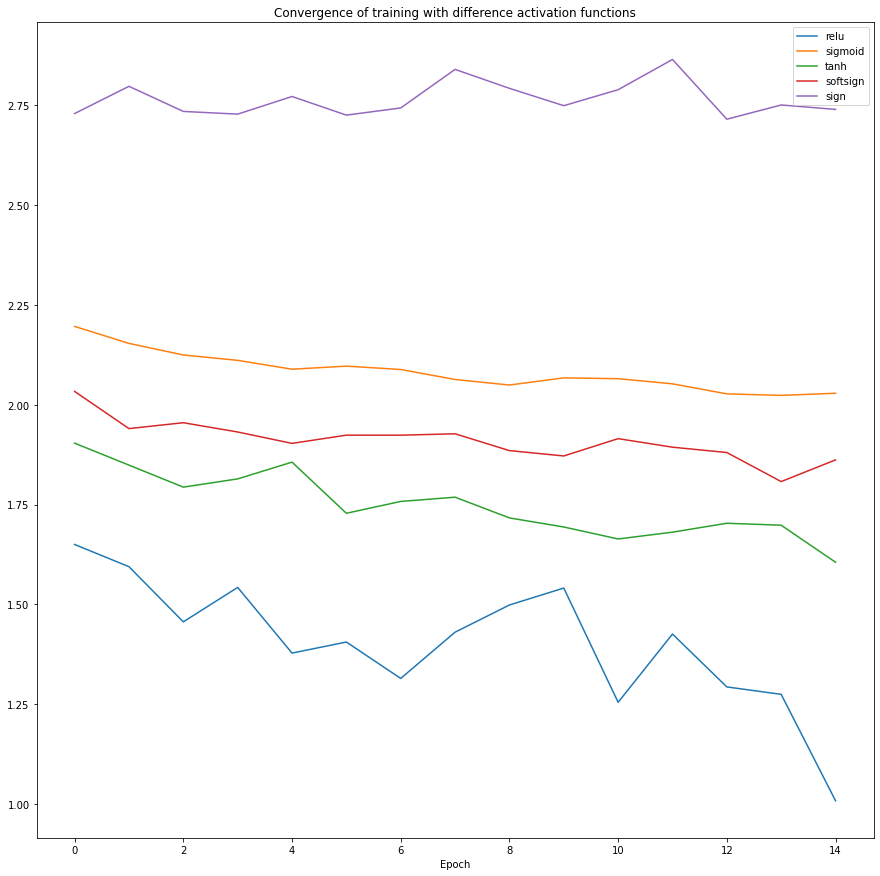

In [18]:
ax = plt.gca()
fig = plt.gcf()

for f_name in train_results:
  ax.plot(train_results[f_name], label=f_name)

ax.legend()
ax.set_xlabel("Epoch")
ax.set_title("Convergence of training with difference activation functions")
fig.set_size_inches(15, 15)

In [20]:
activation_funcs = {
    # 'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh,
    'softsign': F.softsign,
    # 'sign': (lambda x: torch.sign(x))
}

for f_name in activation_funcs:
  print(f"Training model with activation function = {f_name}")
  func = activation_funcs[f_name]
  model = FCNet(func)
  loss_history = train_model(model, learning_rate=1)
  train_results[f_name] = loss_history
  print("")


Training model with activation function = sigmoid
Epoch 0 Loss 2.10   acc=0.35
Epoch 1 Loss 2.00   acc=0.37
Epoch 2 Loss 1.99   acc=0.38
Epoch 3 Loss 1.99   acc=0.39
Epoch 4 Loss 1.96   acc=0.40
Epoch 5 Loss 1.98   acc=0.40
Epoch 6 Loss 1.96   acc=0.41
Epoch 7 Loss 1.94   acc=0.41
Epoch 8 Loss 1.93   acc=0.41
Epoch 9 Loss 1.96   acc=0.41
Epoch 10 Loss 1.98   acc=0.41
Epoch 11 Loss 1.93   acc=0.42
Epoch 12 Loss 1.91   acc=0.42
Epoch 13 Loss 1.95   acc=0.42
Epoch 14 Loss 1.94   acc=0.42

Training model with activation function = tanh


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0 Loss 1.89   acc=0.36
Epoch 1 Loss 1.84   acc=0.35
Epoch 2 Loss 1.82   acc=0.40
Epoch 3 Loss 1.78   acc=0.40
Epoch 4 Loss 1.77   acc=0.40
Epoch 5 Loss 1.81   acc=0.40
Epoch 6 Loss 1.64   acc=0.41
Epoch 7 Loss 1.72   acc=0.42
Epoch 8 Loss 1.71   acc=0.43
Epoch 9 Loss 1.66   acc=0.42
Epoch 10 Loss 1.73   acc=0.42
Epoch 11 Loss 1.66   acc=0.42
Epoch 12 Loss 1.61   acc=0.43
Epoch 13 Loss 1.63   acc=0.42
Epoch 14 Loss 1.61   acc=0.43

Training model with activation function = softsign
Epoch 0 Loss 1.96   acc=0.34
Epoch 1 Loss 1.89   acc=0.36
Epoch 2 Loss 1.87   acc=0.38
Epoch 3 Loss 1.85   acc=0.38
Epoch 4 Loss 1.82   acc=0.39
Epoch 5 Loss 1.80   acc=0.39
Epoch 6 Loss 1.78   acc=0.40
Epoch 7 Loss 1.77   acc=0.41
Epoch 8 Loss 1.78   acc=0.41
Epoch 9 Loss 1.73   acc=0.42
Epoch 10 Loss 1.75   acc=0.42
Epoch 11 Loss 1.73   acc=0.42
Epoch 12 Loss 1.71   acc=0.42
Epoch 13 Loss 1.67   acc=0.42
Epoch 14 Loss 1.71   acc=0.43



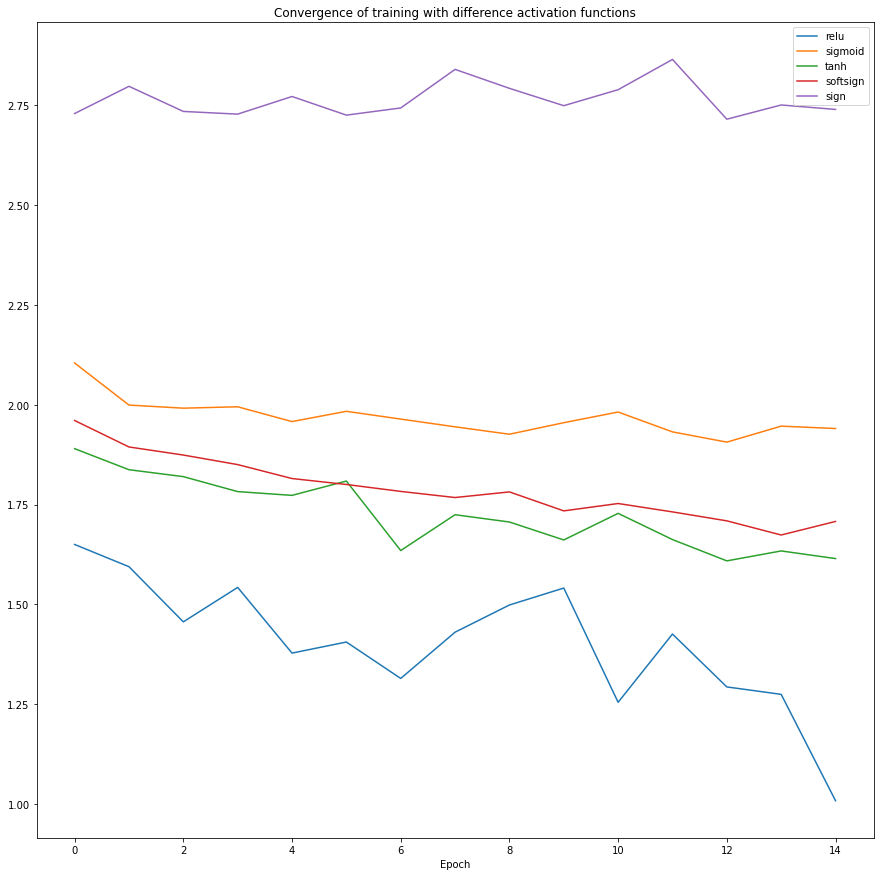

In [21]:
ax = plt.gca()
fig = plt.gcf()

for f_name in train_results:
  ax.plot(train_results[f_name], label=f_name)

ax.legend()
ax.set_xlabel("Epoch")
ax.set_title("Convergence of training with difference activation functions")
fig.set_size_inches(15, 15)

In [22]:
activation_funcs = {
    # 'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh,
    'softsign': F.softsign,
    'sign': (lambda x: torch.sign(x))
}

for f_name in activation_funcs:
  print(f"Training model with activation function = {f_name}")
  func = activation_funcs[f_name]
  model = FCNet(func)
  loss_history = train_model(model, learning_rate=2.5)
  train_results[f_name] = loss_history
  print("")


Training model with activation function = sigmoid


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Loss 2.02   acc=0.37
Epoch 1 Loss 1.98   acc=0.38
Epoch 2 Loss 1.95   acc=0.40
Epoch 3 Loss 1.99   acc=0.41
Epoch 4 Loss 1.95   acc=0.41
Epoch 5 Loss 1.95   acc=0.42
Epoch 6 Loss 1.94   acc=0.42
Epoch 7 Loss 1.91   acc=0.42
Epoch 8 Loss 1.94   acc=0.42
Epoch 9 Loss 1.91   acc=0.43
Epoch 10 Loss 1.90   acc=0.43
Epoch 11 Loss 1.88   acc=0.43
Epoch 12 Loss 1.89   acc=0.44
Epoch 13 Loss 1.89   acc=0.44
Epoch 14 Loss 1.88   acc=0.43

Training model with activation function = tanh


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0 Loss 2.04   acc=0.30
Epoch 1 Loss 1.92   acc=0.35
Epoch 2 Loss 1.92   acc=0.34
Epoch 3 Loss 1.93   acc=0.33
Epoch 4 Loss 1.89   acc=0.36
Epoch 5 Loss 1.78   acc=0.37
Epoch 6 Loss 1.91   acc=0.38
Epoch 7 Loss 1.79   acc=0.36
Epoch 8 Loss 1.81   acc=0.37
Epoch 9 Loss 1.83   acc=0.39
Epoch 10 Loss 1.79   acc=0.37
Epoch 11 Loss 1.91   acc=0.39
Epoch 12 Loss 1.83   acc=0.38
Epoch 13 Loss 1.85   acc=0.39
Epoch 14 Loss 1.81   acc=0.39

Training model with activation function = softsign
Epoch 0 Loss 1.94   acc=0.35
Epoch 1 Loss 1.91   acc=0.37
Epoch 2 Loss 1.87   acc=0.39
Epoch 3 Loss 1.87   acc=0.39
Epoch 4 Loss 1.86   acc=0.40
Epoch 5 Loss 1.84   acc=0.40
Epoch 6 Loss 1.85   acc=0.40
Epoch 7 Loss 1.77   acc=0.39
Epoch 8 Loss 1.76   acc=0.40
Epoch 9 Loss 1.80   acc=0.41
Epoch 10 Loss 1.76   acc=0.42
Epoch 11 Loss 1.76   acc=0.41
Epoch 12 Loss 1.79   acc=0.42
Epoch 13 Loss 1.76   acc=0.42
Epoch 14 Loss 1.73   acc=0.43

Training model with activation function = sign
Epoch 0 Loss 2.78   

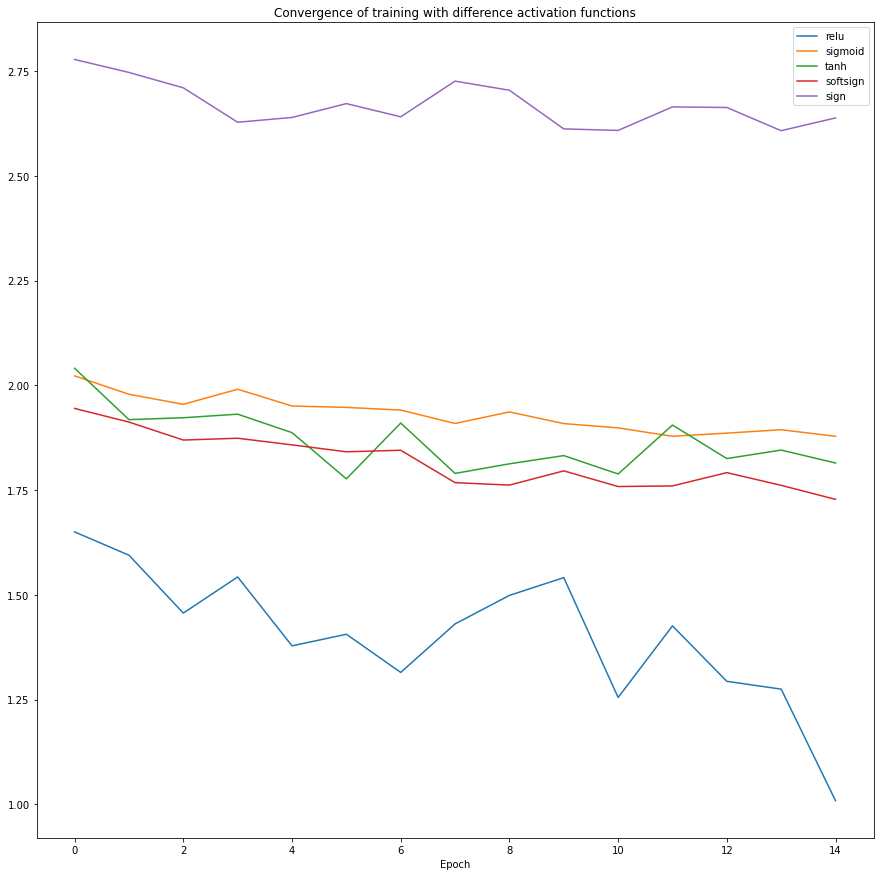

In [23]:
ax = plt.gca()
fig = plt.gcf()

for f_name in train_results:
  ax.plot(train_results[f_name], label=f_name)

ax.legend()
ax.set_xlabel("Epoch")
ax.set_title("Convergence of training with difference activation functions")
fig.set_size_inches(15, 15)

**Промежуточный вывод.** При изменении learning_rate: 0.1 -> 1.0 -> 2.5 функция потерь и точность меняется очень незначительно в моделях, использующих в качестве функции потерь `sigmoid`, `tanh`, `softsign`, `sign`. Функция `sign` показывает себя хуже всех.

А функция RELU оптимизируется на имеющихся данных быстрее всего.

## Итог

В рамках работы удалось достичь точность модели = 0.51. Для этого потребовалось использовать функцию аквтивации RELU для полносвязной нейронной сети из двух слоев. В качестве оптимизатора можно выбирать SGD(with momentum) или Adam. В построенной нейронной сети в первом слое 3072 + 1(для bias)  входа на первом слое, 100 входов на втором слое.

## Пожелания
Хотелось бы получить какой-то вводный гайд, как переносить вычисления на GPU. В рамках работы для себя попробовал, это дало двукратное ускорение для вычисления одной эпохи обучения. Но не стал оставлять в работе, т.к. постоянно ловил проблемы, что один тензор в опреативке, а другой в видеопамяти. Хотел бы увидеть рабочий пример пайплайна обучения, чтобы не городить свои костыли.

## Ideas for extra work
* Evaluate Batch Normalization effect (need a deeper network) 